In [1]:
%matplotlib inline
%load_ext autoreload
%load_ext memory_profiler
%autoreload 2

import sys, os
sys.path.append('../largescale_smc/')
sys.path.append('../third_party')

In [14]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm
import sys

from time import time
from largescale_missingness import *
from largescale_utils_data import *
from largescale_dataset import *

In [6]:
from surprise import SVD
from surprise import accuracy

In [7]:
%%memit
start_time = time()
#file_path = os.path.expanduser("../data/ml-100k/u.data")
file_path = os.path.expanduser("../data/ml-10m/ratings_no_timestamp.dat")
reader = DataReader(line_format="user item rating", sep="::")
splitter = DataSplitter(file_path, reader)
print(f"Elapsed time: {time()-start_time} seconds")

Elapsed time: 9.572393417358398 seconds
peak memory: 4578.53 MiB, increment: 2201.94 MiB


In [26]:
random_state=0

n_ratings=len(splitter.raw_ratings)
test_size=int(n_ratings*0.01)
train_size=n_ratings-test_size

rng = np.random.default_rng(seed=random_state)
permutation = rng.permutation(n_ratings)
raw_trainset = [splitter.raw_ratings[i] for i in permutation[:train_size]]
raw_testset = [splitter.raw_ratings[i] for i in permutation[train_size : (test_size + train_size)]]

In [27]:
trainset = construct_trainset(raw_trainset, reader.rating_scale)

In [59]:
%%memit
start_time = time()
algo = SVD(n_factors=100, n_epochs=30, biased=False, verbose=True)
algo.fit(trainset)
print(f"Fitting time: {time()-start_time} seconds")

start_time = time()
# Then compute RMSE
predictions = algo.test(raw_testset)
accuracy.rmse(predictions)
print(f"Testing time: {time()-start_time} seconds")

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Fitting time: 167.8976480960846 seconds
RMSE: 0.7860
Testing time: 0.506721019744873 seconds
peak memory: 4097.00 MiB, increment: 78.71 MiB


In [60]:
predictions

[Prediction(uid='28215', iid='5309', r_ui=3.0, est=1.7605897292168207, details={'was_impossible': False}),
 Prediction(uid='56140', iid='3527', r_ui=4.0, est=4.5058512940565505, details={'was_impossible': False}),
 Prediction(uid='48102', iid='1210', r_ui=4.0, est=4.0988535818881395, details={'was_impossible': False}),
 Prediction(uid='35826', iid='3444', r_ui=4.0, est=3.7492303561610667, details={'was_impossible': False}),
 Prediction(uid='44756', iid='1321', r_ui=3.0, est=3.520904767624894, details={'was_impossible': False}),
 Prediction(uid='36083', iid='1129', r_ui=4.0, est=4.082564591788587, details={'was_impossible': False}),
 Prediction(uid='42902', iid='2291', r_ui=3.0, est=2.8621653219118715, details={'was_impossible': False}),
 Prediction(uid='24482', iid='3176', r_ui=3.0, est=4.000740634047576, details={'was_impossible': False}),
 Prediction(uid='9104', iid='1221', r_ui=4.5, est=4.088829295245748, details={'was_impossible': False}),
 Prediction(uid='9892', iid='4545', r_ui=2

In [61]:
for i, pred in enumerate(predictions):
    if pred.iid == '61913':
        print(i, pred)

31264 user: 40976      item: 61913      r_ui = 3.00   est = 3.51   {'was_impossible': True, 'reason': 'User and item are unknown.'}


In [78]:
test_indices=[(urid, irid) for urid, irid, _ in raw_testset]
train_indices=[(urid, irid) for urid, irid, _ in raw_trainset[:100000]]

In [68]:
w_obs = LogisticMFProbs(random_state=random_state)

In [80]:
w_obs.fit(raw_trainset)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:19<00:00,  1.52it/s]


(array([3.3000e+01, 8.9000e+01, 1.6700e+02, 2.8300e+02, 5.1200e+02,
        8.3400e+02, 1.5030e+03, 3.0440e+03, 7.4600e+03, 8.6075e+04]),
 array([0.0182825 , 0.11645424, 0.21462597, 0.31279773, 0.41096944,
        0.50914121, 0.60731292, 0.70548469, 0.8036564 , 0.90182817,
        0.99999988]),
 <BarContainer object of 10 artists>)

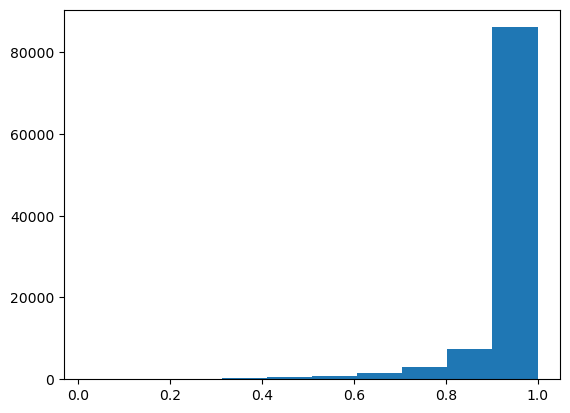

In [81]:
plt.hist(w_obs(train_indices))

(array([   8.,    8.,   18.,   13.,   17.,   31.,   33.,   66.,  141.,
        1665.]),
 array([0.01330745, 0.11197583, 0.2106442 , 0.30931258, 0.40798095,
        0.50664932, 0.60531771, 0.70398605, 0.80265445, 0.90132278,
        0.99999118]),
 <BarContainer object of 10 artists>)

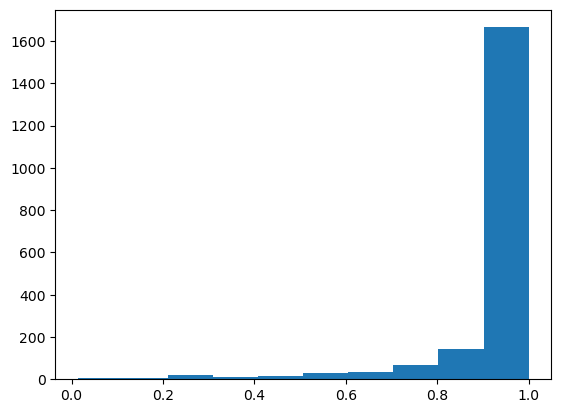

In [82]:
plt.hist(w_obs(test_indices[:2000]))